# 1. DeepLDA: design CVs from equilibrium fluctuations

Reference paper: _Bonati, Rizzi and Parrinello, [JCPL](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535) (2020)_ [[arXiv]](https://arxiv.org/abs/2002.06562). 

The aim of this tutorial is to illustrate how we can design collective variables in a data-driven way, starting from local fluctuations of a set of physical descriptors in the metastable states. 

### Introduction

**DeepLDA summary**

To this extent, we resort to a statistical method called Linear Discriminant Analysis ([LDA](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)). LDA searches for the linear projection $s=\bar{w}^T x$ of the input data $x$ such that the classes are maximally separated. This is measured by the so called Fisher's ratio:

$$\bar{w} = \text{argmax}_w {\frac{wS_b w^T}{wS_w w^T}}$$

where $S_b$ is the scatter matrix between the classes and $S_w$ the one between them. In the simple case of two classes (states) A and B these can be easily computed from the mean and covariance matrices of the data in the states:

$$S_w = \Sigma_A + \Sigma_B $$

$$S_b = (\mu_A-\mu_b)(\mu_A-\mu_b)^T $$

![LDA](images/lda.png)

From a practical perspective, the vector $\bar{w}$ is found by solving the generalized eigenvalue problem: $S_b\bar{w} = v S_w \bar{w} $, where the eigenvalue $v$ measures the amount of separation between the states.

Here we employ a non-linear generalization of LDA in which the mapping function is a neural network (NN). This greatly increases the discriminative power of the model, by learning a set of latent variables in which the metastable states are linearly separable. This is achieved by performing a nonlinear featurization of the inputs via a NN, and then LDA is applied to the outputs of the network. During the training, the parameters of the NN are optimized as to maximize the LDA eigenvalue $v$. In other words, we are transforming the input space in such a way that the discrimination between the states is maximal. 

![DeepLDA scheme](images/DeepLDA_scheme.png)

To achieve this we use the following loss function:

$$ \mathcal{L} = -v - \alpha \frac{1}{1+(\bar{s}^2-1)^2} $$

where the first term correspond to the maximization of the eigenvalue which describe the amount of separation of the two states and the second is a lorentzian regularization of the average value of the output CV, which keep it close to 1.

Note that to stabilize the learning we also regularize the calculation of $S_w$ by adding the identity matrix multiplied by a parameter $\lambda$, as: $S_w '= S_w+\lambda\mathbb{1}$ . The two regularization parameters $\alpha$ and $\lambda$ are not independent, as the former affect the numerator of the Fisher' ratio above and the latter the denominator. Hence in the following we will choose only $\lambda$ and set $\alpha=\frac{2}{\lambda}$.


To apply this method, the only knowledge that is required as initial inputs are the snapshot of the system in different metastable states. These could be for instance the reactant and product of a chemical reaction, a crystalline and a liquid configurations of a material, the bound and unbound states of a ligand into a protein, etc...

Of course, a variable built only by compressing the equilibrium fluctuations in the local minima of the FES into a CV will not be perfect. Rather, it should be seen as a first step which allows to observe some transitions and learn something new on the system that we can later use to refine it and find better CVs.

**Outline**

In this tutorial we take as example **alanine dipeptide** in vacuum, which is often used as a toy model for enhanced sampling methods. This molecule has two metastable states, called $C7_{eq}$ and $C7_{ax}$, which in the following we will refer to as A and B, respectively. 

To mimic a realistic scenario, we assume that we do not know anything about this system but for two realization of the states A and B. 

![Ala 2 metastable states](images/ala2-belfast-2-transition.png)

Using these two realizations of the molecule we proceed as follows:

1. We perform short unbiased MD simulations in the metastable states and evaluate a set of physical descriptors (e.g. interatomic distances between heavy atoms)
2. We train the DeepLDA CV and inspect it
3. Finally, we apply a bias potential to enhance the fluctuations of the DeepLDA CV and (hopefully) drive the system back and forth between A to B.

## Setup

In [56]:
import mlcvs
import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import pandas as pd

def clean(folder='./'):
    subprocess.run("rm bck.* COLVAR KERNELS alanine.*", cwd=folder, shell=True)

GMX_CMD = 'gmx_mpi'

In [4]:
# Define a few plotting functions

def plot_ramachandran(x,y,z,scatter=None, ax=None):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title(f'Ramachandran plot')

    # Plot countour plot
    h = ax.hexbin(x,y,C=z,cmap='fessa')
    cbar = plt.colorbar(h,ax=ax)
    cbar.set_label(f'Deep-LDA CV')

    axs[0].set_xlabel(r'$\phi$ [rad]')
    axs[0].set_ylabel(r'$\psi$ [rad]')

def plot_cv_histogram(s,label=None,ax=None,**kwargs):
    # Setup plot
    if ax is None:
        _, ax = plt.subplots(figsize=(5,4.), dpi=100)
        ax.set_title('Histogram')

    if (type(s)==torch.Tensor):
        s = s.squeeze(1).detach().numpy()

    # Plot histogram
    ax.hist(s,**kwargs)
    if label is not None:
        ax.set_xlabel(label)

## 1.0 Unbiased simulations in the metastable states

First we perform short MD simulations starting from the two snapshots of the molecule, and characterizing each state with a set of descriptors. To proceed in a blind way, we choose to use as input features all the distances between heavy atoms (the list of such descriptors are in the file `plumed-distances.dat`).

**State A**

In [5]:
folder = '1_DeepLDA/0_unbiased-sA/'
Path(folder).mkdir(parents=True, exist_ok=True)
subprocess.run(f"cp ../md_inputs/input.ala2.pdb ../md_inputs/input.tpr .", cwd=folder, shell=True)

with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute descriptors
INCLUDE FILE=../plumed-distances.dat

# Print 
PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=500000

clean(folder)
subprocess.run(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps} > alanine.out", cwd=folder, shell=True)

rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'KERNELS': No such file or directory
              :-) GROMACS - gmx mdrun, 2021.5-plumed-2.8.0-dev (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Ma

CompletedProcess(args='gmx_mpi mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps 500000 > alanine.out', returncode=0)

**State B**

In [7]:
folder = '1_DeepLDA/0_unbiased-sB/'
Path(folder).mkdir(parents=True, exist_ok=True)
subprocess.run(f"cp ../md_inputs/input.ala2.pdb .", cwd=folder, shell=True)
subprocess.run(f"cp ../md_inputs/input.sB.tpr input.tpr", cwd=folder, shell=True)

with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

INCLUDE FILE=../plumed-distances.dat

PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=500000

clean(folder)
subprocess.run(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps} > alanine.out", cwd=folder, shell=True)

rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'KERNELS': No such file or directory
              :-) GROMACS - gmx mdrun, 2021.5-plumed-2.8.0-dev (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Ma

CompletedProcess(args='gmx_mpi mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps 500000 > alanine.out', returncode=0)

## 1.1 DeepLDA CV on pairwise distances (heavy atoms) 

### (a) Train CV

To load the PLUMED output of the two unbiased MD runs we can use the `load_dataframe` function.
From this data we build our training dataset. Since this is a supervised learning task, the dataset will be of the form (`X,y`), in which `X` are the input samples and `y` the corresponding labels (the states to which they belong to).

In [35]:
from mlcvs.utils.io import load_dataframe
# load state A and assign label 0
folder = '1_DeepLDA/0_unbiased-sA/'
colvarA = load_dataframe(folder+"COLVAR")
colvarA['state']=np.full(len(colvarA),'A')
colvarA['label']=np.full(len(colvarA),0)

# load stateB and assign label 1
folder = '1_DeepLDA/0_unbiased-sB/'
colvarB = load_dataframe(folder+"COLVAR")
colvarB['state']=np.full(len(colvarB),'B')
colvarB['label']=np.full(len(colvarB),1)

# concatenate data into a single dataframe
colvar = pd.concat([colvarA,colvarB.reset_index(drop=True)])

# create training dataset 
X = colvar.filter(regex='d_').values
y = colvar['label'].values

# transform them into torch.tensors 
X = torch.Tensor(X)
y = torch.Tensor(y)

We can take a look at the descriptors, by computing their histogram in the two states. 

--> **Question:** Is there any descriptor that is able to discriminate by its own between the states?

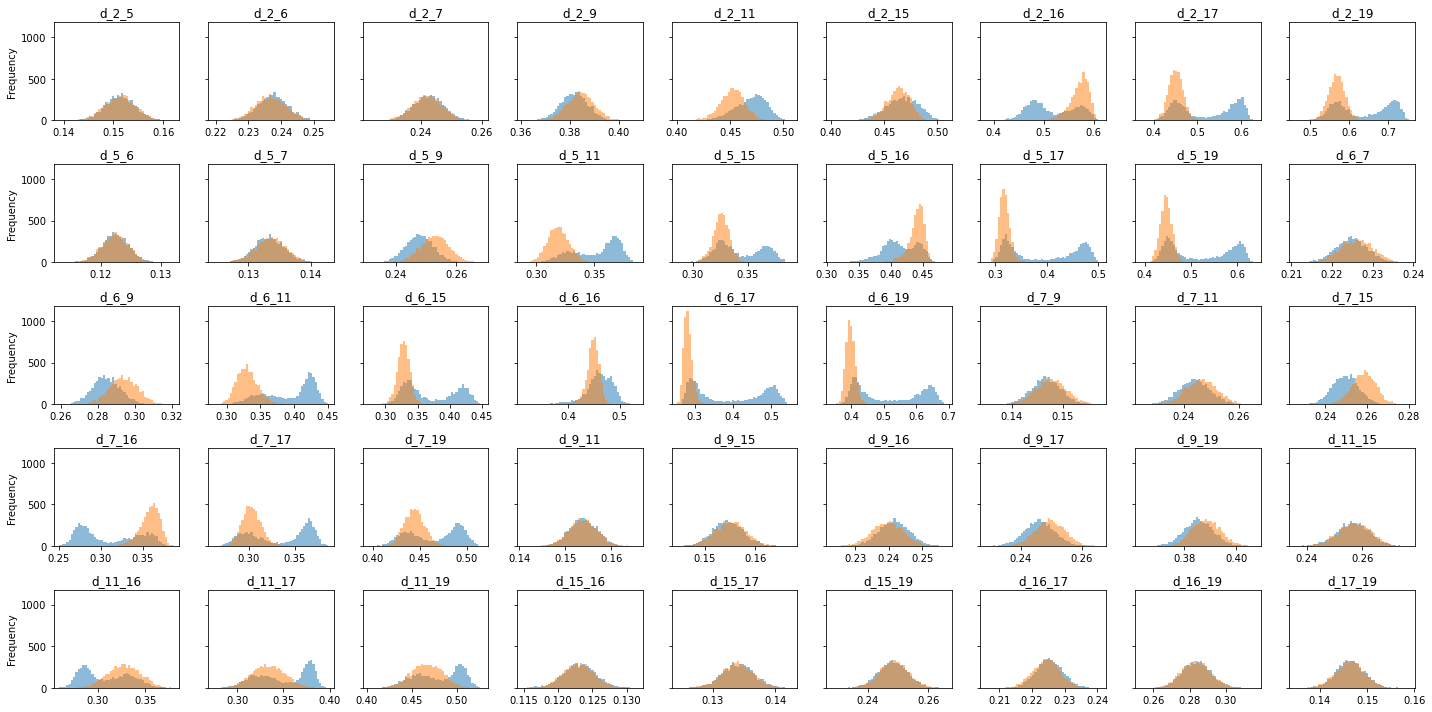

In [36]:
descriptors_names = colvar.filter(regex='d_').columns.values

fig,axs = plt.subplots(5,9,figsize=(20,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    colvar.pivot(columns='state')[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False)
    ax.set_title(desc)

plt.tight_layout()

Here we use the `mlcvs` package to train a DeepLDA CV out of this data. This can be as simple as follows: define the network architecture, specify when to stop to training (e.g. by using early stopping on validation score) and call the fit method. This will output the training and validation score along the training. Let's give it a try!

In [37]:
from mlcvs.lda import DeepLDA_CV
nodes = [X.size(1),30,30,5]

model = DeepLDA_CV(nodes)

# TRAIN
model.set_earlystopping(patience=20,min_delta=0.1)
model.fit(X=X,y=y,log_every=100)

Training   set: 9001
Validation set: 1001
Sw regularization: 0.05
Lorentzian reg.  : 40.0

Epoch Train Loss  Valid Loss  
100   -46.339 -46.724 
200   -62.288 -62.262 
INFO: Early stopping
240   -62.477 -62.460 


However, to better understand what we are doing, we shall consider a more detailed example, in which we analyze the different steps and options. First we create a `TensorDataset` which we divide into training and validation set. From them, we construct `Dataloader`-like objects. The definition of such auxiliary objects is a standard PyTorch practice, which allows us to easily train the models on different devices.

In [38]:
from torch.utils.data import TensorDataset,random_split
from mlcvs.utils.data import FastTensorDataLoader

dataset = TensorDataset(X,y)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_data, valid_data = random_split(dataset,[train_size,valid_size])
train_loader = FastTensorDataLoader(train_data,batch_size=0,shuffle=True) # here 0 means to use a single batch
valid_loader = FastTensorDataLoader(valid_data)

Then, we need to inizialize the neural network and the optimizer and define when to stop the training (EarlyStopping or after a given number of epochs). The following is a list with all the parameters and their explanation.

| Parameter | Type | Description |
| :- | :- | :- |
| **Neural network** |
| nodes | list | NN architecture (last value equal to the number of hidden layers which are input of LDA) |
| activation | string | Activation function (relu,tanh,elu,linear) |
| **Optimization** |
| lrate | float | Learning rate |
| sw_reg | float | S_w matrix regularization ($\lambda$)| 
| l2_reg | float | L2 regularization |
| num_epochs | int | Number of epochs |
| **Early Stopping** |
| es_patience | int | Number of epochs before stopping |
| es_consecutive | bool | Whether es_patience should count consecutive (True) or cumulative patience |
| es_min_delta | float | Minimum decrease of validation loss |
| **Log** |
| log_every | int | How often print the train/valid loss during training |

In [39]:
from mlcvs.lda import DeepLDA_CV

#------------- PARAMETERS -------------
nodes             = [X.size(1),30,30,5]
activation        = 'tanh'

lrate             = 0.001
sw_reg            = 0.05
l2_reg            = 1e-5

num_epochs        = 1000
earlystop         = True
es_patience       = 20
es_consecutive    = True
es_min_delta      = 0.1

log_every         = 100
#--------------------------------------

# DEVICE: check if there is a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL: initialize the DeepLDA CV object
model = DeepLDA_CV(nodes,activation)
model.to(device)

# OPTIMIZER: here we use adam
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)
model.set_optimizer(opt)
model.set_earlystopping(patience=es_patience,consecutive=es_consecutive,min_delta=es_min_delta)

# REGULARIZATION: add regularization to the calculation of the S_w matrix
model.set_regularization(sw_reg=sw_reg)

# TRAIN: fit the model to maximize Fisher's discriminant ratio
model.fit(train_loader,valid_loader, 
            standardize_inputs = True, 
            standardize_outputs = False,
            log_every=log_every)

Epoch Train Loss  Valid Loss  
100   -53.366 -53.279 
200   -61.814 -61.755 
INFO: Early stopping
254   -62.516 -62.481 


After the training we can plot the learning curve to see the training and validation score.

--> **Exercise**: You can try to repeat the training in the cell above and make sure that you find similar values for the loss function. You can examine the behaviour of the NN when changing the NN architecture, and in particular the number of outputs which regulates the space in which LDA is applied.

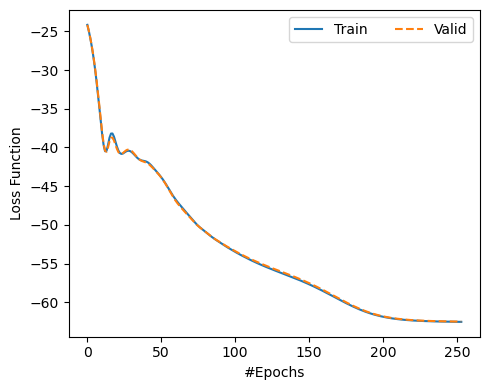

In [40]:
fig, ax = plt.subplots(figsize=(5,4),dpi=100)

loss_train = [x.cpu().numpy() for x in model.loss_train]
loss_valid = [x.cpu().numpy() for x in model.loss_valid]

# Loss function
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

#if model.earlystopping_.early_stop:
#    ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
ax.set_xlabel('#Epochs')
ax.legend(ncol=2)

plt.tight_layout()
plt.show()

To better understand what the network is doing, we can inspect the output of the NN, before the application of LDA. 

--> **Question**: What are the differences with respect to the input descriptors?

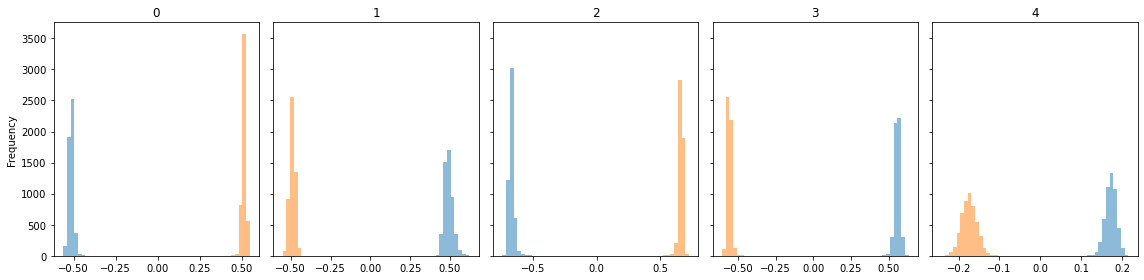

In [41]:
model.output_hidden=True
with torch.no_grad():
    hidden = model(X).numpy()
df = pd.DataFrame( hidden )
df ['label'] = y
model.output_hidden=False

# Plot histogram in the two state
fig,axs = plt.subplots(1,nodes[-1],figsize=(16,4),sharey=True)

hidden_names = [i for i in range(nodes[-1])]

for ax,desc in zip(axs.flatten(),hidden_names):
    df.pivot(columns='label')[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False)
    ax.set_title(desc)

plt.tight_layout()

Finally, we can look at the histogram of the CV (right), which shows that the two states are mapped around -1 and +1. To appreciate the discriminative power, we can also inspect the Ramachandran plot (left) of the two torsion angles phi and psi where we colored the points according to the value of the Deep-LDA CV.

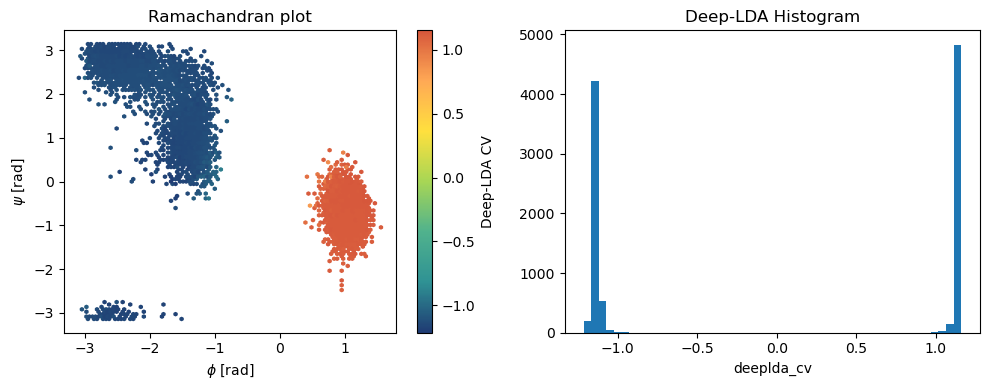

In [42]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

axs[0].set_title('Ramachandran plot')
with torch.no_grad():
    s = model(X)
    
plot_ramachandran(colvar['phi'],colvar['psi'],s,ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Deep-LDA Histogram')
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )

plt.tight_layout()

### (b) Bias DeepLDA

Once we have designed our CV from the data, we can use to to enhance the sampling. To do so, we compile the model using `torch.jit` (this is done inside the `export` function) which creates a python-independent file which can be loaded in PLUMED via the `PYTORCH_MODEL` function. If you look in the export folder below, you will find two files: `model_checkpoint.pt` which can be used to load the model back to Python, and a compiled one, `model.ptc` which we will load in the PLUMED input file. 

PLUMED will use the pytorch C++ APIs to load the model and evaluate it together with its derivatives with automatic differentiation. The outputs of the model will be stored in components called `deep.node-0,deep.node-1,...`, where `deep` is the label assigned to the PLUMED function (see input below).

To apply the bias potential, our method of choice is `OPES`, as it as several advantages to metadynamics (fewer parameters, quickly converges to a quasi-static regime, performs a kernel merging which allows to bias more efficiently multiple CVs, well-behaved adaptive sigma, it can limit the amount of bias deposited...). However, this variable can be used with any other CV-based methods.

--> **Exercise**: look at the PLUMED input file below and fill the missing parameters, then run gromacs.

In [ ]:
folder = '1_DeepLDA/1_opes-deeplda/'
Path(folder).mkdir(parents=True, exist_ok=True)
subprocess.run(f"cp ../0_unbiased-sA/input* .", cwd=folder, shell=True)

# export model
model.export(folder)

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute descriptors
INCLUDE FILE=../plumed-distances.dat

# Compute DeepLDA CV
deep: PYTORCH_MODEL FILE=____FILL____ ARG=d_2_5,d_2_6,d_2_7,d_2_9,d_2_11,d_2_15,d_2_16,d_2_17,d_2_19,d_5_6,d_5_7,d_5_9,d_5_11,d_5_15,d_5_16,d_5_17,d_5_19,d_6_7,d_6_9,d_6_11,d_6_15,d_6_16,d_6_17,d_6_19,d_7_9,d_7_11,d_7_15,d_7_16,d_7_17,d_7_19,d_9_11,d_9_15,d_9_16,d_9_17,d_9_19,d_11_15,d_11_16,d_11_17,d_11_19,d_15_16,d_15_17,d_15_19,d_16_17,d_16_19,d_17_19

# Apply OPES bias 
opes: OPES_METAD ARG=deep.node-0 PACE=500 BARRIER=30

# Print 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=5000000

clean(folder)
subprocess.run(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps} > alanine.out", cwd=folder, shell=True)

In [43]:
## SOLUTION VERSION 

folder = '1_DeepLDA/1_opes-deeplda/'
Path(folder).mkdir(parents=True, exist_ok=True)
subprocess.run(f"cp ../0_unbiased-sA/input* .", cwd=folder, shell=True)

# export model
model.export(folder)

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute descriptors
INCLUDE FILE=../plumed-distances.dat

# Compute DeepLDA CV
deep: PYTORCH_MODEL FILE=model.ptc ARG=d_2_5,d_2_6,d_2_7,d_2_9,d_2_11,d_2_15,d_2_16,d_2_17,d_2_19,d_5_6,d_5_7,d_5_9,d_5_11,d_5_15,d_5_16,d_5_17,d_5_19,d_6_7,d_6_9,d_6_11,d_6_15,d_6_16,d_6_17,d_6_19,d_7_9,d_7_11,d_7_15,d_7_16,d_7_17,d_7_19,d_9_11,d_9_15,d_9_16,d_9_17,d_9_19,d_11_15,d_11_16,d_11_17,d_11_19,d_15_16,d_15_17,d_15_19,d_16_17,d_16_19,d_17_19

# Apply OPES bias
opes: OPES_METAD ARG=deep.node-0 PACE=500 BARRIER=30

# Print 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=5000000

clean(folder)
subprocess.run(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps} > alanine.out", cwd=folder, shell=True)

rm: cannot remove 'bck.*': No such file or directory
              :-) GROMACS - gmx mdrun, 2021.5-plumed-2.8.0-dev (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        

CompletedProcess(args='gmx_mpi mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps 5000000 > alanine.out', returncode=0)

Once the simulation is over we can plot the time evolution of the Deep-LDA CV, in which several transitions between the states A and B (-1 and 1) can be observed. Furthermore, we can look at the Ramachandran plot to see the explored region.

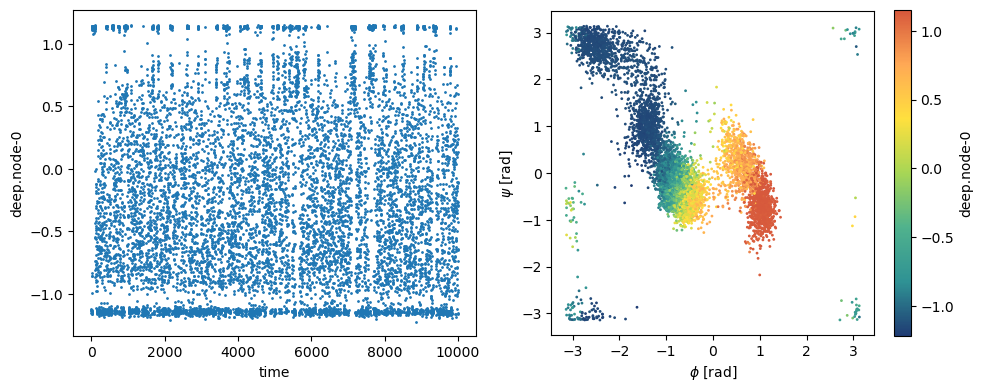

In [44]:
folder = '1_DeepLDA/1_opes-deeplda/'
colvar = load_dataframe(folder+'COLVAR')

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=100)
# Time evolution (DeepLDA)
colvar.plot.scatter('time','deep.node-0',s=1,ax=axs[0])
axs[1].set_xlabel('Time [ps]')
axs[1].set_xlabel('DeepLDA')
# 2D scatter plot colored with DeepLDA
colvar.plot.scatter('phi','psi',c='deep.node-0',s=1,cmap='fessa',ax=axs[1])
axs[1].set_xlabel(r'$\phi$ [rad]')
axs[1].set_ylabel(r'$\psi$ [rad]')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

From this simulation we can compute the free energy surface as a function of the DeepLDA CV. To do so, we use the `compute_fes` function which performs a (weighted) block average. 

--> **Exercise**: calculate the FES as a function of other variables, such as the Ramachandran angles `phi` and `psi`.

(0.0, 50.0)

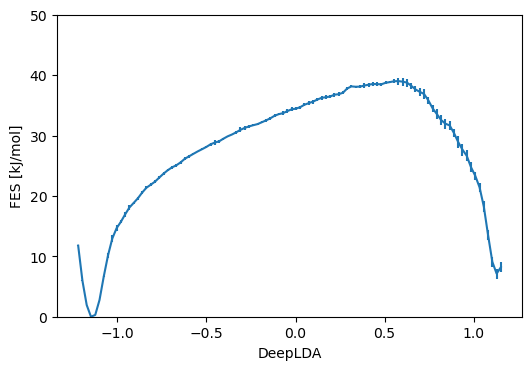

In [45]:
from mlcvs.utils.fes import compute_fes

s = colvar['deep.node-0'].values

# compute weights
kbT = 2.5
w = np.exp(colvar['opes.bias'].values/kbT)

fig,ax = plt.subplots(figsize=(6,4),dpi=100)
fes,grid,bounds,error = compute_fes(s, weights=w, kbt=kbT, 
                                    blocks=5, bandwidth=0.02, 
                                    plot=True, ax = ax)
ax.set_xlabel('DeepLDA')
ax.set_ylabel('FES [kJ/mol]')
ax.set_ylim(0,50)

Once we have obtained a reasonable sampling, we can try to understand what the NN has learnt. A naive guess would be to compute the correlation between the DeepLDA CV and all the input distances. 

--> **Question**: Can we identify some features that are more correlated than others? You can also try to use `method='spearman'` in the correlation function, which rather than looking for a linear correlation only assesses how well the relationship between two variables can be described using a monotonic function.

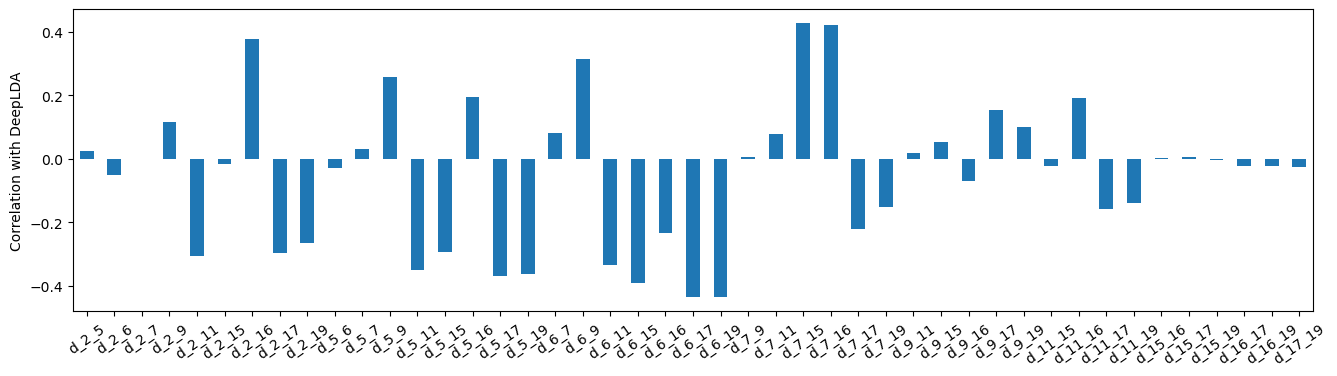

In [46]:
cols = ['deep.node-0']
cols.extend(colvar.filter(regex='d_').columns)
corr = colvar[cols].corr(method='pearson') 

fig,ax = plt.subplots(figsize=(16,4),dpi=100)

corr['deep.node-0'].drop('deep.node-0').plot(kind='bar', ax=ax, rot=35)
ax.set_ylabel('Correlation with DeepLDA')
plt.show()

Since the relationship between the input distances and the DeepLDA CV is not linear, understanding what the NN has learnt might not be an easy job. Hovewer, we could try to see whether we detect any correlation with respect to other physical descriptors which might play a role in the transition between the two states. 

--> **Exercise**: compute the correlation between the DeepLDA CV and the torsion angles computed in the PLUMED input file.

In [ ]:
# select deelda and input distances, as well as dihedral angles
cols = ['deep.node-0', ______FILL______ ]

# compute correlation
corr = colvar[cols].corr(method='spearman')

# plot
fig,ax = plt.subplots(figsize=(4,4),dpi=100)
corr['deep.node-0'].drop('deep.node-0').plot(kind='bar', ax=ax, rot=35)
ax.set_ylabel('Correlation with DeepLDA')
plt.show()

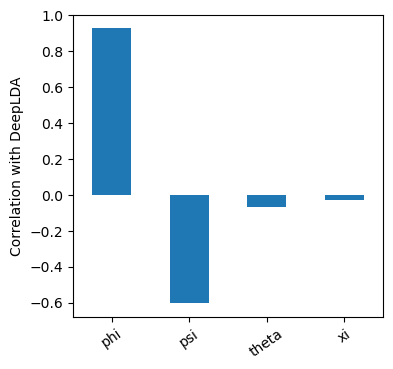

In [47]:
# SOLUTION VERSION

# select deelda and input distances, as well as dihedral angles
cols = ['deep.node-0', 'phi', 'psi', 'theta', 'xi' ]

# compute correlation
corr = colvar[cols].corr(method='spearman')

# plot
fig,ax = plt.subplots(figsize=(4,4),dpi=100)
corr['deep.node-0'].drop('deep.node-0').plot(kind='bar', ax=ax, rot=35)
ax.set_ylabel('Correlation with DeepLDA')
plt.show()

### Bonus exercise

As you might have noticed, the DeepLDA CV acts as a powerful classifier, which maps the equilibrium fluctuations into very narrow distributions. Although we were using OPES with adaptive bandwitdh estimation, this might still lead to artifacts in the enhanced sampling dynamics. To address this behaviour we can work on the regularization of the NN (e.g. penalty functions to the loss function) or, in this case, we can more simply stretch it. Since the states are mapped (due to the lorentzian regularization) on a sphere of radius ~ 1.1, if we use a function of the kind `s' = s + s^N` we obtain a transformation of the CV which is approximately linear around zero and amplifies the fluctuations around 1. In the picture below you can see the case for N=3. 

You can try to repeat the enhanced sampling simulation biasing a function of the CV, using the `CUSTOM` PLUMED keyword, e.g.:

`deep_mod: CUSTOM ARG=deep.node-0 FUNC=x+x^3 PERIODIC=NO`

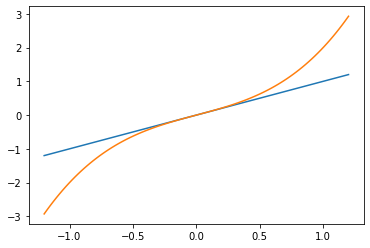

In [48]:
x = np.linspace(-1.2,1.2,100)
plt.plot(x,x)
plt.plot(x,x+x**3)
plt.show()

## 1.2 DeepLDA on dihedral angles

To illustrate how the results are robust with respect to the set of descriptors used, we can repeat the exercise by using a different set of descriptors, namely the torsion angles. To inform the model about the periodicity of the angular variables we first compute sine and cosine of them and use these variables as input features.

### (a) Train CV

In [49]:
from mlcvs.utils.io import load_dataframe

# load state A and assign label 0
folder = '1_DeepLDA/0_unbiased-sA/'
colvarA = load_dataframe(folder+"COLVAR")
colvarA['state']=np.full(len(colvarA),'A')
colvarA['label']=np.full(len(colvarA),0)

# load stateB and assign label 1
folder = '1_DeepLDA/0_unbiased-sB/'
colvarB = load_dataframe(folder+"COLVAR")
colvarB['state']=np.full(len(colvarB),'B')
colvarB['label']=np.full(len(colvarB),1)

# concatenate data
colvar = pd.concat([colvarA,colvarB.reset_index(drop=True)])

Compute sine and cosine

In [50]:
for ang in ['phi','psi','theta','xi']:
    colvar['sin_'+ang] = np.sin(colvar[ang])
    colvar['cos_'+ang] = np.cos(colvar[ang])

# create training set 
X = colvar.filter(regex='sin_|cos_').values
y = colvar['label'].values

# transform them into torch.tensors 
X = torch.Tensor(X)
y = torch.Tensor(y)

colvar.filter(regex='sin_|cos_')

,sin_phi,cos_phi,sin_psi,cos_psi,sin_theta,cos_theta,sin_xi,cos_xi
0,-0.698230,-0.715873,0.477030,-0.878887,-0.200882,0.979615,0.048037,0.998846
1,-0.901231,-0.433338,0.865888,-0.500238,0.182209,0.983260,-0.177264,0.984163
2,-0.905004,0.425402,0.582461,-0.812859,-0.277958,0.960593,0.290362,0.956917
3,-0.997085,-0.076299,0.856517,-0.516119,0.229455,0.973319,-0.182814,0.983148
4,-0.992699,-0.120619,0.853790,-0.520617,-0.323724,0.946151,0.034455,0.999406
...,...,...,...,...,...,...,...,...
4996,0.828744,0.559628,-0.912760,0.408497,0.081186,0.996699,-0.055580,0.998454
4997,0.804022,0.594599,-0.725990,0.687705,0.147673,0.989036,0.072975,0.997334
4998,0.926668,0.375880,-0.485138,0.874438,0.079018,0.996873,0.130381,0.991464
4999,0.834275,0.551349,-0.364537,0.931189,-0.093380,0.995630,-0.189787,0.981825


Split train / valid data

In [51]:
from torch.utils.data import TensorDataset,random_split
from mlcvs.utils.data import FastTensorDataLoader

dataset = TensorDataset(X,y)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_data, valid_data = random_split(dataset,[train_size,valid_size])
train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

Train the CV

In [52]:
from mlcvs.lda import DeepLDA_CV

#------------- PARAMETERS -------------
nodes             = [X.size(1),10,10,2]
activation        = 'tanh'

lrate             = 0.001
sw_reg            = 0.05
l2_reg            = 1e-5

num_epochs        = 1000
earlystop         = True
es_patience       = 20
es_consecutive    = True
es_min_delta      = 0.1

log_every         = 100
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepLDA_CV(nodes,activation)
model.to(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)
model.set_optimizer(opt)

# REGULARIZATION
model.set_regularization(sw_reg=sw_reg)
model.set_earlystopping(patience=es_patience,consecutive=es_consecutive,min_delta=es_min_delta)

# TRAIN
model.fit(train_loader,valid_loader, 
            standardize_inputs = True, 
            standardize_outputs = False,
            log_every=log_every)

Epoch Train Loss  Valid Loss  
100   -46.905 -47.147 
200   -57.870 -58.177 
300   -60.637 -60.625 
400   -61.457 -61.420 
INFO: Early stopping
476   -61.886 -61.856 


Plot the learning curve

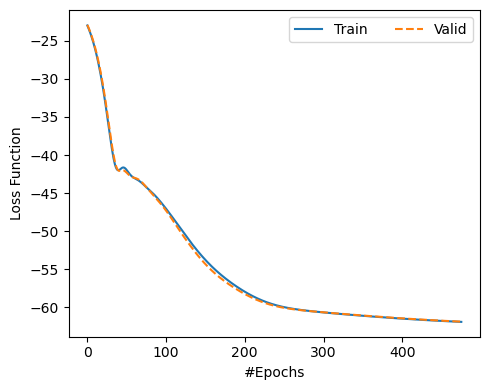

In [53]:
fig, ax = plt.subplots(figsize=(5,4),dpi=100)

loss_train = [x.cpu().numpy() for x in model.loss_train]
loss_valid = [x.cpu().numpy() for x in model.loss_valid]

# Loss function
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

#if model.earlystopping_.early_stop:
#    ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
ax.set_xlabel('#Epochs')
ax.legend(ncol=2)

plt.tight_layout()
plt.show()

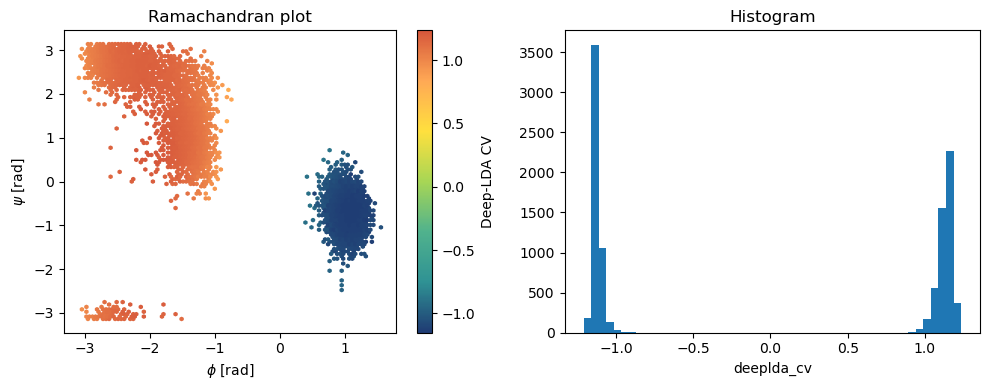

In [54]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

phi = colvar['phi']
psi = colvar['psi']

axs[0].set_title('Ramachandran plot')
with torch.no_grad():
    s = model(X)
plot_ramachandran(phi,psi,s,ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = model(X)
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )

plt.tight_layout()

### (b) Bias DeepLDA

If we want to bias such CV, besides exporting the model we also need to specify to PLUMED to calculate the actual input descriptors, which are sine and cosine of the torsions.

--> **Exercise**: modify the PLUMED input below as to compute all the necessary descriptors.

In [ ]:
folder = '1_DeepLDA/2_opes-deeplda-torsions/'
Path(folder).mkdir(parents=True, exist_ok=True)
subprocess.run(f"cp ../0_unbiased-sA/input* .", cwd=folder, shell=True)

# export model
model.export(folder)

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute sin / cos of torsions
sin_phi: CUSTOM ARG=phi FUNC=sin(x) PERIODIC=NO
_____FILL_____


# Compute descriptors
#INCLUDE FILE=../plumed-distances.dat

# Compute DeepLDA CV
deep: PYTORCH_MODEL FILE=model.ptc ARG=sin_phi,_____FILL_____

deep_mod: CUSTOM ARG=deep.node-0 FUNC=x+x^3 PERIODIC=NO

# Apply OPES bias
opes: OPES_METAD ARG=deep_mod PACE=500 BARRIER=30

# Print 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=5000000

clean(folder)
subprocess.run(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps} > alanine.out", cwd=folder, shell=True)

In [59]:
## SOLUTION VERSION

folder = '1_DeepLDA/2_opes-deeplda-torsions/'
Path(folder).mkdir(parents=True, exist_ok=True)
subprocess.run(f"cp ../0_unbiased-sA/input* .", cwd=folder, shell=True)

# export model
model.export(folder)

# write plumed input
with open(folder+"plumed.dat","w") as f:
    print("""
# vim:ft=plumed

# Compute torsion angles, as well as energy
MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
theta: TORSION ATOMS=6,5,7,9
xi: TORSION ATOMS=16,15,17,19
ene: ENERGY

# Compute sin / cos of torsions
sin_phi: CUSTOM ARG=phi FUNC=sin(x) PERIODIC=NO
cos_phi: CUSTOM ARG=phi FUNC=cos(x) PERIODIC=NO
sin_psi: CUSTOM ARG=psi FUNC=sin(x) PERIODIC=NO
cos_psi: CUSTOM ARG=psi FUNC=cos(x) PERIODIC=NO
sin_theta: CUSTOM ARG=theta FUNC=sin(x) PERIODIC=NO
cos_theta: CUSTOM ARG=theta FUNC=cos(x) PERIODIC=NO
sin_xi: CUSTOM ARG=xi FUNC=sin(x) PERIODIC=NO
cos_xi: CUSTOM ARG=xi FUNC=cos(x) PERIODIC=NO

# Compute descriptors
#INCLUDE FILE=../plumed-distances.dat

# Compute DeepLDA CV
deep: PYTORCH_MODEL FILE=model.ptc ARG=sin_phi,cos_phi,sin_psi,cos_psi,sin_theta,cos_theta,sin_xi,cos_xi

deep_mod: CUSTOM ARG=deep.node-0 FUNC=x+x^3 PERIODIC=NO

# Apply OPES bias
opes: OPES_METAD ARG=deep_mod PACE=500 BARRIER=30

# Print 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=f)

## RUN GROMACS
num_steps=5000000

clean(folder)
subprocess.run(f"{GMX_CMD} mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps {num_steps} > alanine.out", cwd=folder, shell=True)

rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'COLVAR': No such file or directory
rm: cannot remove 'KERNELS': No such file or directory
              :-) GROMACS - gmx mdrun, 2021.5-plumed-2.8.0-dev (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Jus

CompletedProcess(args='gmx_mpi mdrun -s input.tpr -deffnm alanine -plumed plumed.dat -ntomp 1 -nsteps 5000000 > alanine.out', returncode=137)

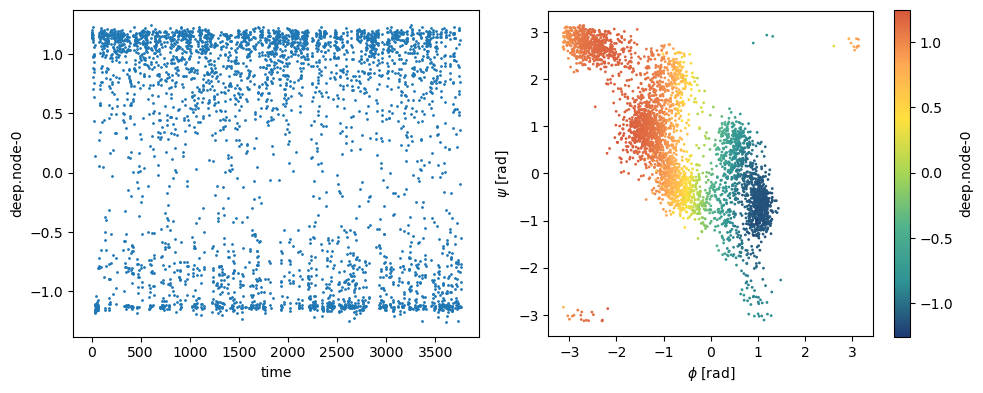

In [60]:
folder = '1_DeepLDA/2_opes-deeplda-torsions/'
colvar = load_dataframe(folder+'COLVAR')

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=100)
# Time evolution (DeepLDA)
colvar.plot.scatter('time','deep.node-0',s=1,ax=axs[0])
axs[1].set_xlabel('Time [ps]')
axs[1].set_xlabel('DeepLDA')
# 2D scatter plot colored with DeepLDA
colvar.plot.scatter('phi','psi',c='deep.node-0',s=1,cmap='fessa',ax=axs[1])
axs[1].set_xlabel(r'$\phi$ [rad]')
axs[1].set_ylabel(r'$\psi$ [rad]')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

As before, we can inspect the correlation between the DeepLDA CV and the inputs. As we might imagine, this time it is easier to detect a strong relationship between a few inputs and the learned representation.

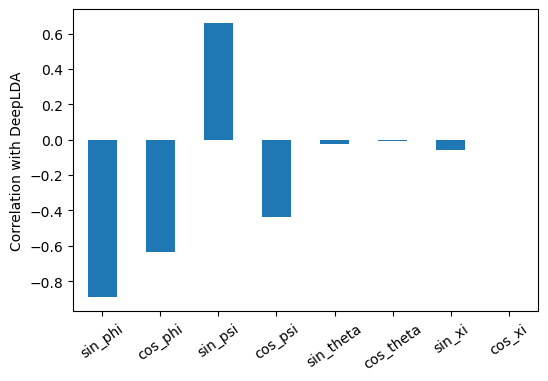

In [61]:
cols = ['deep.node-0']
cols.extend(colvar.filter(regex='sin_|cos_').columns)
corr = colvar[cols].corr(method='spearman')

fig,ax = plt.subplots(figsize=(6,4),dpi=100)

corr['deep.node-0'].drop('deep.node-0').plot(kind='bar', ax=ax, rot=35)
ax.set_ylabel('Correlation with DeepLDA')
plt.show()

## Extra: comparison with standard (H)LDA

Load unbiased dataset

In [14]:
from mlcvs.utils.io import load_dataframe
# load state A and assign label 0
folder = 'ala2/unbiased-sA/'
colvarA = load_dataframe(folder+"COLVAR")
colvarA['state']=np.full(len(colvarA),'A')
colvarA['label']=np.full(len(colvarA),0)

# load stateB and assign label 1
folder = 'ala2/unbiased-sB/'
colvarB = load_dataframe(folder+"COLVAR")
colvarB['state']=np.full(len(colvarB),'B')
colvarB['label']=np.full(len(colvarB),1)

# concatenate data into a single dataframe
colvar = pd.concat([colvarA,colvarB.reset_index(drop=True)])

HLDA on heavy atoms distances

In [16]:
from mlcvs.lda import LDA_CV

# training dataset 
X = colvar.filter(regex='d_').values
y = colvar['label'].values

# transform them into torch.tensors 
X = torch.Tensor(X)
y = torch.Tensor(y)

# fit the CV
model = LDA_CV(n_features=X.size(1),harmonic_lda=True)

model.fit(X=X,y=y)

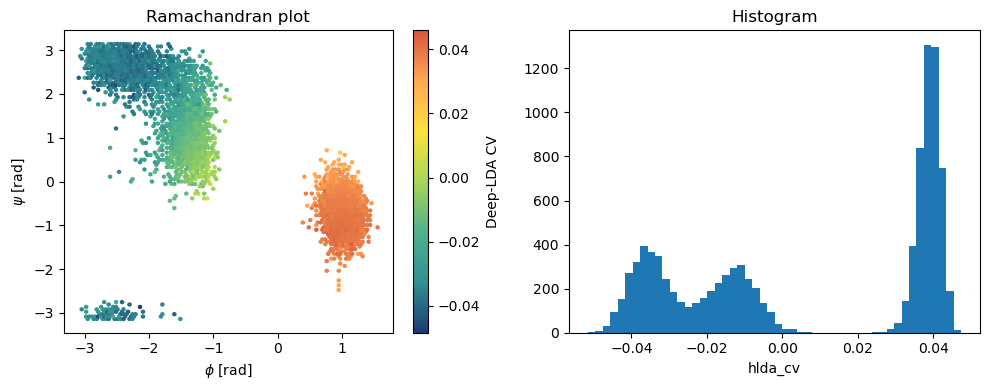

In [19]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

phi = colvar['phi']
psi = colvar['psi']

axs[0].set_title('Ramachandran plot')
with torch.no_grad():
    s = model(X)
plot_ramachandran(phi,psi,s,ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = model(X)
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )

plt.tight_layout()

HLDA on torsion angles

In [20]:
from mlcvs.lda import LDA_CV

# training dataset 
X = colvar.filter(regex='phi|psi|theta|chi').values
y = colvar['label'].values

# transform them into torch.tensors 
X = torch.Tensor(X)
y = torch.Tensor(y)

# fit the CV
model = LDA_CV(n_features=X.size(1),harmonic_lda=True)

model.fit(X=X,y=y)

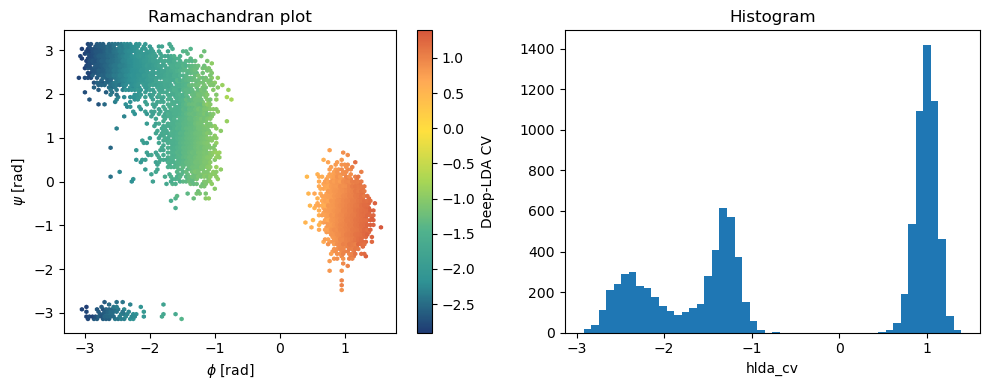

In [21]:
_, axs = plt.subplots(1,2, figsize=(10,4.), dpi=100)

phi = colvar['phi']
psi = colvar['psi']

axs[0].set_title('Ramachandran plot')
with torch.no_grad():
    s = model(X)
plot_ramachandran(phi,psi,s,ax=axs[0])

# Calculate CV values over training set
axs[1].set_title(f'Histogram')
s = model(X)
plot_cv_histogram(s,label=model.name_,bins=50, ax=axs[1] )

plt.tight_layout()